In [12]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

In [13]:
def get_window(raw, annotation):
    window = raw.copy().crop(tmin=annotation['onset'], tmax=annotation['onset']+annotation['duration'])
    
    return window

def get_window_dict(raw, annotations):
    window_dict = {}

    for description in np.unique(annotations.description):

        list_of_windows = []
        for annotation in annotations[annotations.description==description]:
            list_of_windows.append(get_window(raw, annotation))

        window_dict[description] = list_of_windows

    return window_dict

In [14]:
edf_file_path = 'notebooks/S001R03.edf'
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()

In [15]:
raw = get_raw(edf_file_path, filter=True)
annotations = get_annotations(edf_file_path)
annotation_dict = get_window_dict(raw, annotations)

In [16]:
src = get_src(src_path)
fwd = get_fwd(raw.info, trans, src_path, bem_path)
cov = get_cov(raw)

In [22]:
parcellation_name = "aparc.a2009s"
labels = get_labels(subjects_dir, parcellation_name = parcellation_name)

In [18]:
vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

In [19]:
compute_inverse = make_fast_inverse_operator(raw.info, fwd, cov, snr=3)

In [67]:
def calculate_activity_per_label(annotation_dict, labels):
    activity = {}

    for anno in annotation_dict.keys():
        activity[anno] = np.empty((len(annotation_dict[anno]), sum(len(hemi) for hemi in labels)))
        for i, window in enumerate(annotation_dict[anno]):
            stc = compute_inverse(window)
            activity[anno][i] = np.concatenate(get_power_per_label(stc, labels, standardize=True))

    return activity

In [59]:
from pathlib import Path
mmidb_path = Path(r"/mnt/c/Users/anders/OneDriveDTU/Dokumenter/BENDR-XAI/data/eegmmidb/files")

In [69]:
from collections import defaultdict

In [125]:
dataset_activity = dict(dataset_activity)
snr = 1.0

In [126]:
np.save("mmidb_{}_{}".format(parcellation_name, str(round(snr, 1))), dataset_activity)


In [87]:
dataset_activity = defaultdict(lambda: {})

pbar = tqdm()

for (dirpath, _, filenames) in os.walk(mmidb_path):
    for filename in filenames:
        if filename.endswith(".edf"):
            
            raw = get_raw(edf_file_path, filter=True)
            annotations = get_annotations(edf_file_path)
            annotation_dict = get_window_dict(raw, annotations)
            activity = calculate_activity_per_label(annotation_dict, labels)

            dataset_activity[dirpath.split('/')[-1]][filename[:-4]] = activity
            pbar.update(1)
            print("Yes")
            pbar.set_description(filename[:-4])

pbar.close()


S001R07: : 7it [01:50, 15.81s/it]
S001R01: : 1it [00:17, 17.30s/it]

Yes


KeyboardInterrupt: 

In [25]:
stc = compute_inverse(annotation_dict['T0'][0])
get_power_per_label(stc, labels).flatten()

AttributeError: 'list' object has no attribute 'flatten'

In [55]:
window = annotation_dict['T1'][7]
stc = compute_inverse(window)
activity = get_power_per_label(stc, labels, standardize=True)

In [40]:
values = activity_to_source_values(activity, labels, sources)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

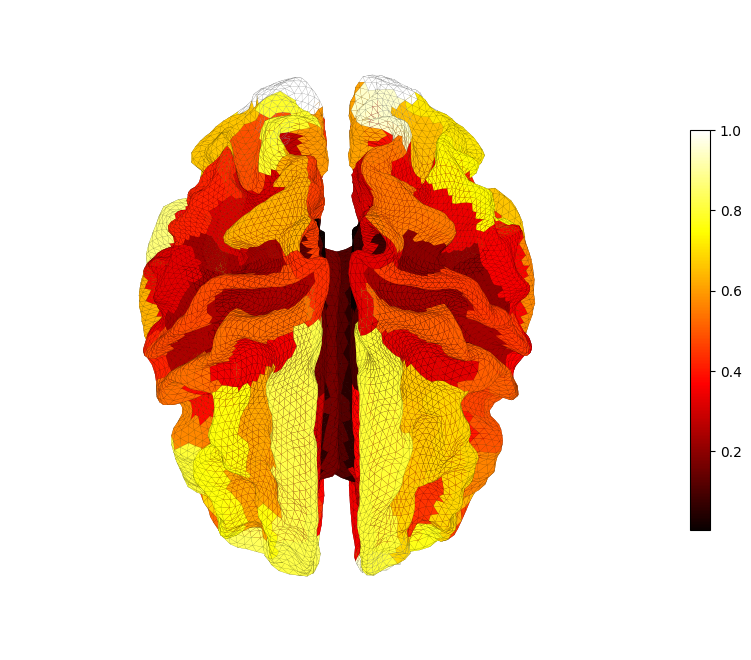

In [41]:
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

lh_mesh.set_array(tris_values[0])
fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
#fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, 90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()

## Brain region activity sort

In [31]:
for i in range(len(labels[0])):
    lh_idx = np.argsort(activity[0])[::-1][i]
    rh_idx = np.argsort(activity[1])[::-1][i]
    lh_name = labels[0][lh_idx].name
    rh_name = labels[1][rh_idx].name
    print('{0:.2f} {1:55}  {2:.2f} {3}'.format(activity[0][lh_idx], lh_name, activity[1][rh_idx], rh_name))

0.80 G_and_S_subcentral-lh                                    1.00 G_and_S_paracentral-rh
0.73 G_and_S_paracentral-lh                                   0.94 G_parietal_sup-rh
0.69 G_front_inf-Opercular-lh                                 0.65 S_cingul-Marginalis-rh
0.64 G_precentral-lh                                          0.62 G_precuneus-rh
0.61 S_precentral-inf-part-lh                                 0.61 Pole_occipital-rh
0.60 G_precuneus-lh                                           0.61 G_postcentral-rh
0.59 G_temp_sup-G_T_transv-lh                                 0.61 G_occipital_sup-rh
0.59 G_temp_sup-Lateral-lh                                    0.60 S_intrapariet_and_P_trans-rh
0.56 S_circular_insula_inf-lh                                 0.58 G_pariet_inf-Angular-rh
0.54 G_parietal_sup-lh                                        0.58 S_postcentral-rh
0.54 S_precentral-sup-part-lh                                 0.58 G_and_S_subcentral-rh
0.53 G_and_S_cingul-Mid-Post-lh       

## Brain activity plot

In [48]:
sources[0].shape

(10242, 3)

In [49]:
tmp.data[10242:,0]

array([1400.08494401,  889.65557425, 1965.12385648, ..., 1605.81052996,
       1228.42071515, 1041.69398191])

In [51]:
values = np.sum(stc.data**2, axis=1).reshape(2, 10242)
tris_values = vertex_values_to_tris_values(values, tris_sources, func=np.max)

%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

lh_mesh = ax.plot_trisurf(*sources[0].T, triangles=tris_sources[0], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="viridis")

lh_mesh.set_array(tris_values[0])
fig.colorbar(lh_mesh, shrink=0.5)

rh_mesh = ax.plot_trisurf(*sources[1].T, triangles=tris_sources[1], linewidth=0.1, shade=False,
                        antialiased=True, edgecolor=(0,0,0,0.5), cmap="hot")

rh_mesh.set_array(tris_values[1])
fig.colorbar(rh_mesh, shrink=0.5)

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(90, 90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()

: 

: 